## Example: Computing Allocation Drift without Active Portfolio Management
This example will familiarize students with the notion of portfolio drift, i.e., the change in the optimal allocation that occurs after a portfolio is established and nothing is done to reallocate the assets in the portfolio.

#### Why does drift occur?
The weight of asset $i$ in a portfolio $\mathcal{P}$ is allocated based upon the _value fraction_ of the total portfolio value. Initially, that value is the budget you have allocated to risky assets; however, the portfolio’s value changes over time because of price fluctuations. The _value fraction_ of asset $i$ in portfolio $\mathcal{P}$ is given by:
$$
\omega_{i} = \frac{n_{i}\cdot{S}_{i}}{\sum_{j\in\mathcal{P}}n_{j}\cdot{S}_{j}}\qquad\forall{i}\in\mathcal{P}
$$
where $n_{i}$ denotes the number of shares of asset $i$, and $S_{i}$ denotes the share price of asset $i$. The numerator is the value of asset $i$ in the portfolio, while the denominator is the portfolio’s total value. Thus, because share prices change, the optimal allocation $\omega_{i}$ drifts over time if the number of shares of each asset stays the same. 
* __Consequence__: If we do nothing, our portfolio is only optimal in the minimum-variance sense until the next trade, i.e., until the next market tick in which any of the assets in the portfolio $\mathcal{P}$ experience a price change.

#### Learning tasks
* __Prerequisites__: We'll begin by loading the historical dataset consisting of daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`.
* __Task 1__: Load Efficient Frontier Set and Select a Portfolio. In this task, we'll load up some minimum variance portfolios computed for a small random selection of ticker symbols. 
* __Task 2__: Compute the number of shares in portfolio $\mathcal{P}$. In this task, we'll compute the initial number of shares in the portfolio $\mathcal{P}$ given the abovementioned initial allocation.
* __Task 3__: Compute the wealth of portfolio $\mathcal{P}$ versus an alternative investment. In this task, we'll compare the wealth generated from our portfolio $\mathcal{P}$ versus an alternative, in this case, the same budget $\mathcal{B}$ invested in `SPY.`
* __Task 4__: Compute the allocation drift of portfolio $\mathcal{P}$. In this task, let's compute the asset allocation $\omega_{i}$ as a function of time (and market conditions), where the number of shares of each asset was specified by the selected optimal solution (portfolio along the efficient frontier).

## Setup
We set up the computational environment by including [the `Include.jl` file](Include.jl). The [`Include.jl` file](Include.jl) loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the [load(...) method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl.git).

In [5]:
original_dataset = load(joinpath(_PATH_TO_DATA, 
        "SP500-Daily-OHLC-1-3-2018-to-12-29-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array:

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;
K = length(list_of_all_tickers); # how many equities are we considering?

Finally, let's get the 2023 `SPY` data (which we'll use as an alternative investment strategy) from the `dataset::Dict{String, DataFrame}.` We'll store this in the `SPY_df::DataFrame` variable:

In [13]:
startdate = Date(2023,01,03); # We will start our portfolio at the close of this day
SPY_dataset = dataset["SPY"];
SPY_df = filter(:timestamp => x-> x >= startdate, SPY_dataset);

## Task 1: Load Efficient Frontier Set and Select a Portfolio
In this task, we'll load up some minimum variance portfolios computed for a small random selection of ticker symbols. Once we load the collection of portfolios, we'll select a portfolio, look at its composition, and proceed to the next task.

Let's start by loading the saved portfolio file. The file is [an HDF5 binary file](https://en.wikipedia.org/wiki/Hierarchical_Data_Format), which we load using commands from [the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl) and [the FileIO.jl package](https://github.com/JuliaIO/FileIO.jl). We saved this as a dictionary, where the dataset key points to the allocation data. We store the portfolio data in the `efficient_frontier::DataFrame` variable:

In [15]:
efficient_frontier = load(joinpath(_PATH_TO_DATA,
        "EfficientFrontier-PortfolioDriftExample-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["dataset"]

Row,expected_excess_return,risk,tickers,w,risk_free_rate
,Float64,Float64,Array…,Array…,Float64
1,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59536e-8, 4.84921e-7, 0.506115]",0.05
2,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59536e-8, 4.85803e-7, 0.506115]",0.05
3,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59537e-8, 4.87577e-7, 0.506115]",0.05
4,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80374e-8, 9.59542e-8, 5.32657e-7, 0.506115]",0.05
5,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80382e-8, 9.59546e-8, 5.69075e-7, 0.506115]",0.05
6,0.0388449,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80362e-8, 9.59585e-8, 1.40028e-6, 0.506114]",0.05
7,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80366e-8, 9.59546e-8, 5.08398e-7, 0.506115]",0.05
8,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80371e-8, 9.59552e-8, 5.25002e-7, 0.506115]",0.05
9,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80333e-8, 9.60306e-8, 1.00265e-6, 0.506114]",0.05


#### Select a portfolio index
Next, select an index for a portfolio to explore in the `portfolio_index::Int64` variable:

In [17]:
portfolio_index = 64; # any value from 1 -> 64

Now, let's look at what is in the selected portfolio:

In [19]:
my_list_of_tickers = efficient_frontier[portfolio_index,:tickers];
w = efficient_frontier[portfolio_index,:w] .|> x-> round(x,digits=6) .|> abs;
expected_excess_return = efficient_frontier[portfolio_index,:expected_excess_return] |> x-> round(x,digits=3)
println("The expected excess return for portfolio index $(portfolio_index) equals $(expected_excess_return)")

The expected excess return for portfolio index 64 equals 0.286


`Unhide` the code block below to see how we constructed an allocation table for the selected portfolio:

In [21]:
let
    tmp_df = DataFrame();
    for i ∈ eachindex(w)
        wᵢ = w[i];
        row_df = (
            ticker = my_list_of_tickers[i],
            allocation = wᵢ
        );
        push!(tmp_df, row_df);
    end
    pretty_table(tmp_df, tf=tf_simple)
end;

========= =============
  ticker   allocation 
  String      Float64 
========= =============
     PFE          0.0
     MRK     0.021794
     AMD     0.978206
      MU          0.0
    INTC          0.0
     SPY          0.0
========= =============


## Task 2: Compute the number of shares in portfolio $\mathcal{P}$
In this task, we'll compute the initial number of shares in the portfolio $\mathcal{P}$ given the abovementioned initial allocation. First, let's specify the budget $\mathcal{B}$ to invest in risky assets, and then store this value in the `total_budget::Float64` variable:

In [23]:
total_budget = 1000.0; # How much do we want to invest initially? units: USD

Next, get the share price at the close of the market for each asset in the portfolio for the `startdate::Date.` We'll store these values in the `Sₒ::Array{Float64,1}` variable:

In [25]:
Sₒ = let
    Sₒ = Array{Float64,1}()
    for ticker ∈ my_list_of_tickers
        price_df = dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close]
        push!(Sₒ,startprice)
    end
    Sₒ;
end

6-element Vector{Float64}:
  51.26
 111.14
  64.02
  50.37
  26.73
 380.82

Finally, now that we have the `total_budget,` and the share price array `Sₒ,` we compute the number of shares of each asset that corresponds to the optimal allocation (the point in the efficient frontier) and store these values in the `Nₒ::Array{Float64,1}` variable (in this case, we allow for fractional shares). The initial (optimal) number of shares is given by:
$$
n_{i} = \frac{\mathcal{B}\cdot\omega_{i}}{S_{\circ,i}}\quad\forall{i}\in\mathcal{P}
$$
where $\mathcal{B}$ denotes the investment inital budget, $S_{\circ,i}$ denotes the initial share price for asset $i$, and $\omega_{i}$ denotes the allocation fraction for asset $i$. We'll store the initial number of shares in the `Nₒ::Array{Float64,1}` variable.

In [27]:
Nₒ = let
    Nₒ = Array{Float64,1}()
    for i ∈ eachindex(w)
        
        wᵢ = w[i]
        nᵢ = (wᵢ*total_budget)/Sₒ[i];
        push!(Nₒ,nᵢ)
    end
    Nₒ
end;
Nₒ

6-element Vector{Float64}:
  0.0
  0.19609501529602305
 15.27969384567323
  0.0
  0.0
  0.0

#### Check: Do we recover the original allocation?
We should be able to recover the initial allocation $\omega_{i}$ by solving the share count problem backward, i.e., start with shares $n_{i}$ and then compute allocation $\omega_{i}$. If this doesn't work, then [an AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) will be thrown:

In [29]:
test_array = Array{Float64,1}();
for i ∈ eachindex(w)
    
    Bᵢ = Nₒ[i]*Sₒ[i];
    push!(test_array, Bᵢ);
end
Z = sum(test_array);
w_test = (1/Z).*test_array

# assert -
for i ∈ eachindex(w)
    @assert(isapprox(w_test[i],w[i], atol=1e-6))
end

## Task 3: Compute the wealth of portfolio $\mathcal{P}$ versus an alternative investment
In this task, we'll compare the wealth generated from our portfolio $\mathcal{P}$ versus an alternative, in this case, the same budget $\mathcal{B}$ invested in `SPY.`

Let's compute the value of a portfolio $\mathcal{P}$ for a `number_of_days` forward in time, where the initial composition of the portfolio $\mathcal{P}$ lies on the efficient frontier. To start, let's specify how many days to compute in the `number_of_days::Int64` variable:

In [31]:
number_of_days = 250; # we hold this the entire trading year

Next, let's compute the performance of portfolio $\mathcal{P}$ by computing the value of each asset in the portfolio and the total value of the portfolio, starting from the initial allocation. We'll store this data in the `portfolio_performance_array` array
* Each `row` of the `portfolio_performance_array` corresponds to a `date,` while each `column` corresponds to an asset in the portfolio, with the last column holding the total value of the portfolio $\mathcal{P}$ at a particular time. We'll use the close price of each asset.

In [33]:
portfolio_performance_array = let
    portfolio_performance_array = Array{Float64,2}(undef, number_of_days, length(w)+1)
    for i ∈ eachindex(my_list_of_tickers)
        
        ticker = my_list_of_tickers[i];
        price_df = dataset[ticker];
        ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
        nᵢ = Nₒ[i]
        
        for j ∈ 1:number_of_days
            portfolio_performance_array[j,i] = nᵢ*ticker_data[j,:close]; # what is the value of the portfolio at close
        end
    end
    
    # total -
    for i ∈ 1:number_of_days
        portfolio_performance_array[i,end] = sum(portfolio_performance_array[i,1:end-1])
    end
    portfolio_performance_array;
end

250×7 Matrix{Float64}:
 0.0  21.794    978.206  0.0  0.0  0.0  1000.0
 0.0  21.9783   987.985  0.0  0.0  0.0  1009.96
 0.0  22.2842   952.383  0.0  0.0  0.0   974.668
 0.0  22.5196   977.289  0.0  0.0  0.0   999.809
 0.0  21.645   1027.41   0.0  0.0  0.0  1049.05
 0.0  21.7293  1039.78   0.0  0.0  0.0  1061.51
 0.0  21.7803  1055.22   0.0  0.0  0.0  1077.0
 0.0  21.9175  1081.8    0.0  0.0  0.0  1103.72
 0.0  22.0117  1084.86   0.0  0.0  0.0  1106.87
 0.0  21.6587  1093.87   0.0  0.0  0.0  1115.53
 0.0  21.3332  1077.68   0.0  0.0  0.0  1099.01
 0.0  21.5508  1034.59   0.0  0.0  0.0  1056.14
 0.0  21.5587  1070.65   0.0  0.0  0.0  1092.21
 ⋮                                 ⋮    
 0.0  21.0037  2111.5    0.0  0.0  0.0  2132.5
 0.0  20.7625  2108.6    0.0  0.0  0.0  2129.36
 0.0  20.6115  2126.17   0.0  0.0  0.0  2146.78
 0.0  20.7939  2122.35   0.0  0.0  0.0  2143.14
 0.0  20.8822  2141.45   0.0  0.0  0.0  2162.33
 0.0  20.6606  2069.94   0.0  0.0  0.0  2090.6
 0.0  20.8625  2137.78   0

Now, let's compute the performance of investing budget $\mathcal{B}$ is `SPY.`.

In [35]:
SPY_performance_array = let

    # initialize -
    SPY_performance_array = Array{Float64,1}(undef, number_of_days);
    
    # how many shares of SPY do we buy?
    Sₒ = SPY_df[1, :close];
    nₒ = total_budget/Sₒ;

    # compute the performance
    for i ∈ 1:number_of_days
        S = SPY_df[i, :close];
        SPY_performance_array[i] = S*nₒ;
    end
    SPY_performance_array;
end

250-element Vector{Float64}:
 1000.0
 1007.7201827635103
  996.2186859933827
 1019.0641247833622
 1018.4864240323512
 1025.6289060448505
 1038.6009138175516
 1042.382227824169
 1046.4261330812458
 1044.5092169528912
 1028.0184864240323
 1020.5346357859356
 1039.546242319206
    ⋮
 1235.4918334121107
 1239.4569612940497
 1232.4195157817342
 1239.351924793866
 1246.8882936820544
 1229.6097894018171
 1241.2688409222205
 1243.763457801586
 1249.0152828107766
 1251.2735675647286
 1251.7462318155558
 1248.1224725592144

#### Visualize
`Unhide` the code block below to see how we visualized the relative wealth of the portfolio $W_{t}/W_{o}$ for our selected optimal portfolio versus an alternative portfolio consisting of `SPY` over the same time frame (where the daily price is taken to be the close price).

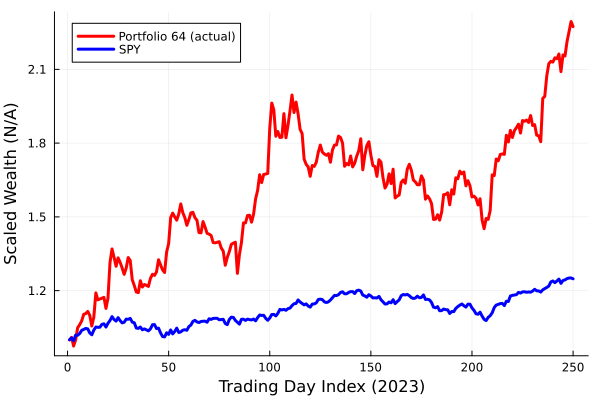

In [37]:
let
    plot((1/total_budget).*portfolio_performance_array[:,end], lw=3, 
        c=:red, label="Portfolio $(portfolio_index) (actual)")
    plot!((1/total_budget).*SPY_performance_array, lw=3, 
        c=:blue, label="SPY")
    xlabel!("Trading Day Index (2023)", fontsize=18)
    ylabel!("Scaled Wealth (N/A)", fontsize=18)
end

## Task 4: Compute the allocation drift of portfolio $\mathcal{P}$
In this task, let's compute the asset allocation $\omega_{i}$ as a function of time (and market conditions), where the number of shares of each asset was specified by the selected optimal solution (portfolio along the efficient frontier).
* __Hypothesis__: Because of price movement, we expect that the initial (optimal) allocation will change over time even though the number of shares held for each asset $n_{i}$ is held constant.

Let's compute the `drift_array::Array{Float64,2}` array, which holds the fraction of the liquidation value held in any given ticker (column) for each day of the trading period. 

In [39]:
drift_array = let
    drift_array = Array{Float64,2}(undef, number_of_days, length(w) + 1)
    for i ∈ 1:number_of_days
        
        total_portfolio_value = portfolio_performance_array[i,end];
        for j ∈ eachindex(my_list_of_tickers)
            drift_array[i,j] = (1/total_portfolio_value).*portfolio_performance_array[i,j]
        end
        drift_array[i,end] = sum(drift_array[i,1:end-1])
    end
    drift_array;
end;

### Visualize
`Unhide` the code block below to see how we visualize the portfolio allocation fractions $\omega_{i}$ for each asset in the portfolio as a function of time.

In [41]:
let
    column_name_array = Array{String,1}();
    for ticker ∈ my_list_of_tickers
        push!(column_name_array, ticker);
    end
    push!(column_name_array, "total")
    df = DataFrame(drift_array, column_name_array)
    pretty_table(df, tf=tf_simple)
end

========== ============ ========== ========= ========= ========= ==========
      PFE          MRK        AMD        MU      INTC       SPY     total 
  Float64      Float64    Float64   Float64   Float64   Float64   Float64 
========== ============ ========== ========= ========= ========= ==========
      0.0     0.021794   0.978206       0.0       0.0       0.0       1.0
      0.0    0.0217615   0.978238       0.0       0.0       0.0       1.0
      0.0    0.0228634   0.977137       0.0       0.0       0.0       1.0
      0.0    0.0225239   0.977476       0.0       0.0       0.0       1.0
      0.0    0.0206329   0.979367       0.0       0.0       0.0       1.0
      0.0    0.0204701    0.97953       0.0       0.0       0.0       1.0
      0.0    0.0202232   0.979777       0.0       0.0       0.0       1.0
      0.0    0.0198579   0.980142       0.0       0.0       0.0       1.0
      0.0    0.0198864   0.980114       0.0       0.0       0.0       1.0
      0.0    0.0194156   0.98058

## Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.